In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics
import re
import sklearn
import nltk
#nltk.download('omw-1.4')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import sys 
!{sys.executable} -m pip install tensorflow-addons
import contractions
from bs4 import BeautifulSoup
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import train_test_split
import torch
#!pip install scikit-learn-intelex
from ast import literal_eval
from sklearnex import patch_sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install pyxlsb
from sklearn import metrics


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
imported_tf_df= pd.read_excel("ar-2010-2014-xlsb.xlsb")
imported_fs_df= pd.read_excel("ar-2015-2016-xlsb.xlsb")

tf_df= imported_tf_df
fs_df= imported_fs_df

In [ ]:
def clean_data(tf_df, fs_df):
    df= pd.concat([tf_df, fs_df])
    df.columns = df.columns.str.lower()
    df= df[["patient age at treatment", 'total number of previous ivf cycles','total number of ivf pregnancies',
        'total number of live births - conceived through ivf', "type of infertility - female primary",
        "type of infertility - female secondary","type of infertility - male primary",
        "type of infertility - male secondary","type of infertility -couple primary",
        "type of infertility -couple secondary", "cause  of infertility - tubal disease",
        "cause of infertility - ovulatory disorder", "cause of infertility - male factor",
        "cause of infertility - patient unexplained", "cause of infertility - endometriosis",
        "cause of infertility - cervical factors", "cause of infertility - female factors",
        "cause of infertility - partner sperm concentration", "cause of infertility -  partner sperm morphology",
        "causes of infertility - partner sperm motility", "cause of infertility -  partner sperm immunological factors",
        "stimulation used", "egg source", "sperm from", "fresh cycle", "frozen cycle", "eggs thawed",
        "fresh eggs collected", "eggs mixed with partner sperm", "embryos transfered", "pgs", "pgd",
        "main reason for producing embroys storing eggs", "specific treatment type", "live birth occurrence"]]
    df.columns = df.columns.str.replace(' ', '_')
    #If the source of sperm and egg is from the same couple, i.e., Partner and Patient, then those patient records are 
    #considered, the rest are eliminated. 
    
    
    df=df[df["egg_source"] == 'Patient'] 
    df = df.drop('egg_source', axis=1)

    df=df[df["sperm_from"] == 'Partner'] 
    df = df.drop('sperm_from', axis=1)

    
    df = df[df.pgd != 1.0]
    df = df.drop('pgd', axis=1)

    df = df[df.pgs != 1.0]
    df = df.drop('pgs', axis=1)
    
    
    df=df[df["main_reason_for_producing_embroys_storing_eggs"] == 'Treatment Now '] 
    df = df.drop('main_reason_for_producing_embroys_storing_eggs', axis=1)

    
    df=df[df["specific_treatment_type"] != 'Unknown'] 
    df = df.drop('specific_treatment_type', axis=1)
    

    
    #In IVF, injectable medication containing both follicle-stimulating hormone (FSH) and luteinizing hormone (LH) is 
    #injected into females to stimulate more than one egg developing at a time45. It is described as "Stimulation Used" 
    #in the dataset; this study considers only patient records where stimulation is done.

    df=df[df["stimulation_used"] == 1] 
    df = df.drop('stimulation_used', axis=1)
    
    print((df['live_birth_occurrence'] == 1).sum())
    
    df = df.drop('cause_of_infertility_-__partner_sperm_immunological_factors', axis=1)
    df = df.drop('cause_of_infertility_-_female_factors', axis=1)
    
    
    #Helllo
    from sklearn.preprocessing import LabelEncoder
    lab = LabelEncoder()

    df['patient_age_at_treatment'] = df['patient_age_at_treatment'].replace('-', '', regex=True).replace(' ', '', regex=True).astype(int)
    mask = df['patient_age_at_treatment'] != 999
    df = df[mask]
    df['patient_age_at_treatment'] = lab.fit_transform(df['patient_age_at_treatment'])

    df = df.fillna(0) 

    df= df.reset_index()
    df= df.drop(['index'], axis=1)
    return df


In [ ]:
def balance_df(df):
    live_birth_df= df[df.live_birth_occurrence == 1]
    num_live_births= live_birth_df.shape[0]
    no_live_birth_df= df[df.live_birth_occurrence == 0]
    no_live_birth_sample_df= no_live_birth_df.sample(num_live_births)

    balanced_df= pd.concat([live_birth_df, no_live_birth_sample_df])
    return (balanced_df)



In [ ]:
def datatypes_cleaning(balanced_df):
    balanced_df['total_number_of_previous_ivf_cycles']= balanced_df['total_number_of_previous_ivf_cycles'].replace(['>=5'], '5')
    balanced_df['total_number_of_ivf_pregnancies']= balanced_df['total_number_of_ivf_pregnancies'].replace(['>=5'], '5')
    balanced_df['fresh_eggs_collected']= balanced_df['fresh_eggs_collected'].replace(['> 50'], '50')
    balanced_df['eggs_mixed_with_partner_sperm']= balanced_df['eggs_mixed_with_partner_sperm'].replace(['> 50'], '50')
    balanced_df[["total_number_of_previous_ivf_cycles", "total_number_of_ivf_pregnancies", "fresh_eggs_collected", "eggs_mixed_with_partner_sperm"]] = balanced_df[["total_number_of_previous_ivf_cycles", "total_number_of_ivf_pregnancies", "fresh_eggs_collected", "eggs_mixed_with_partner_sperm"]].applymap(np.int64)
    balanced_df[["fresh_cycle", "frozen_cycle", "eggs_thawed", "embryos_transfered", "live_birth_occurrence"]] = balanced_df[["fresh_cycle", "frozen_cycle", "eggs_thawed", "embryos_transfered", "live_birth_occurrence"]].applymap(np.int64)
    return balanced_df

In [ ]:
def scale_dataframe(balanced_df):
    scaled_df = balanced_df.copy() 
    for column in scaled_df.columns: 
        scaled_df[column] = scaled_df[column]  / scaled_df[column].abs().max() 
    return scaled_df    


In [ ]:
def train_test(dataframe):
    y= dataframe["live_birth_occurrence"]
    X= dataframe.drop(["live_birth_occurrence"], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, stratify=y)
    return y, X, X_train, X_test, y_train, y_test


In [ ]:
def heatmap(dataframe):
    import seaborn as sns
    corr = dataframe.corr()
    matrix = np.triu(corr)
    cmap = sns.diverging_palette(170, 20, as_cmap=True, center= "light")
    # using the upper triangle matrix as mask 
    sns.set_theme(rc={'figure.figsize':(23,15)})
    vmax= 0.91
    sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap, vmin=-vmax, vmax=vmax)

heatmap(scaled_df)

# Code

In [ ]:
df = clean_data(tf_df, fs_df)
print(df)

In [ ]:
balanced_df= balance_df(df)
print(balanced_df)

In [ ]:
cleaned_df= datatypes_cleaning(balanced_df)
print(cleaned_df)

In [ ]:
y, X, X_train, X_test, y_train, y_test= train_test(cleaned_df)

item_list=[y, X, X_train, X_test, y_train, y_test]
for item in train_test_list():
    item= scale_dataframe(item)


In [ ]:
print(X_test)

In [78]:
classifiers_df= pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1','AUC'])

In [79]:
roc_df= pd.DataFrame(columns=['Classifier', 'fpr', 'tpr', 'auc'])

Random Forest 

In [81]:
first_rf_model = RandomForestClassifier(n_estimators=5000)
first_rf_model.fit(X_train, y_train)

y_pred = first_rf_model.predict(X_test)
confusion_matrix(y_test, y_pred)
confusion= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.show()
accuracy_score(y_test, y_pred)

MemoryError: Unable to allocate 787. KiB for an array with shape (100694,) and data type int64

In [46]:
#calculate Accuracy and AUC of model

y_pred_proba = first_rf_model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)


0.6921681313470256


In [47]:
importances= first_rf_model.feature_importances_
columns= X.columns
i=0

while i < len(columns):
    print({columns[i]})
    print({importances[i]})
    i=i+1

{'patient_age_at_treatment'}
{0.09601993570147684}
{'total_number_of_previous_ivf_cycles'}
{0.09109804386547093}
{'total_number_of_ivf_pregnancies'}
{0.01559988264547004}
{'total_number_of_live_births_-_conceived_through_ivf'}
{0.009859284513092184}
{'type_of_infertility_-_female_primary'}
{0.0021812724469588564}
{'type_of_infertility_-_female_secondary'}
{0.0014025106685850203}
{'type_of_infertility_-_male_primary'}
{0.002075155258220975}
{'type_of_infertility_-_male_secondary'}
{0.0014395069795670923}
{'type_of_infertility_-couple_primary'}
{0.0021886934112315534}
{'type_of_infertility_-couple_secondary'}
{0.0009307816702073812}
{'cause__of_infertility_-_tubal_disease'}
{0.018623197433097073}
{'cause_of_infertility_-_ovulatory_disorder'}
{0.014582262985513553}
{'cause_of_infertility_-_male_factor'}
{0.018680667510973317}
{'cause_of_infertility_-_patient_unexplained'}
{0.017945720259270225}
{'cause_of_infertility_-_endometriosis'}
{0.01596335013146297}
{'cause_of_infertility_-_cervica

In [27]:

# Number of trees in random forest
#generally the more, the better
n_estimators = [100,500,1000,1500]


# Number of features to consider at every split
#can be an integer, a fraction of the number of features, the square root of num features, or log2 features
max_features = [1]


# Maximum number of levels in tree
#too shallow and we miss details. Too much is overfitting
max_depth = [15,17,19,21,23,25]
max_depth.append(None)


# Minimum number of samples required to split a node
#too small can be overfitting, too large is less accurate 
min_samples_split = [2,4,8]


# Minimum number of samples required at each leaf node
#too small can be overfitting, too large is less accurate 
min_samples_leaf = [2,4,8]


# Method of selecting samples for training each tree
bootstrap = [False]
#[True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 500, 1000, 1500], 'max_features': [1], 'max_depth': [15, 17, 19, 21, 23, 25, None], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [2, 4, 8], 'bootstrap': [False]}


In [28]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 21, 'bootstrap': False}


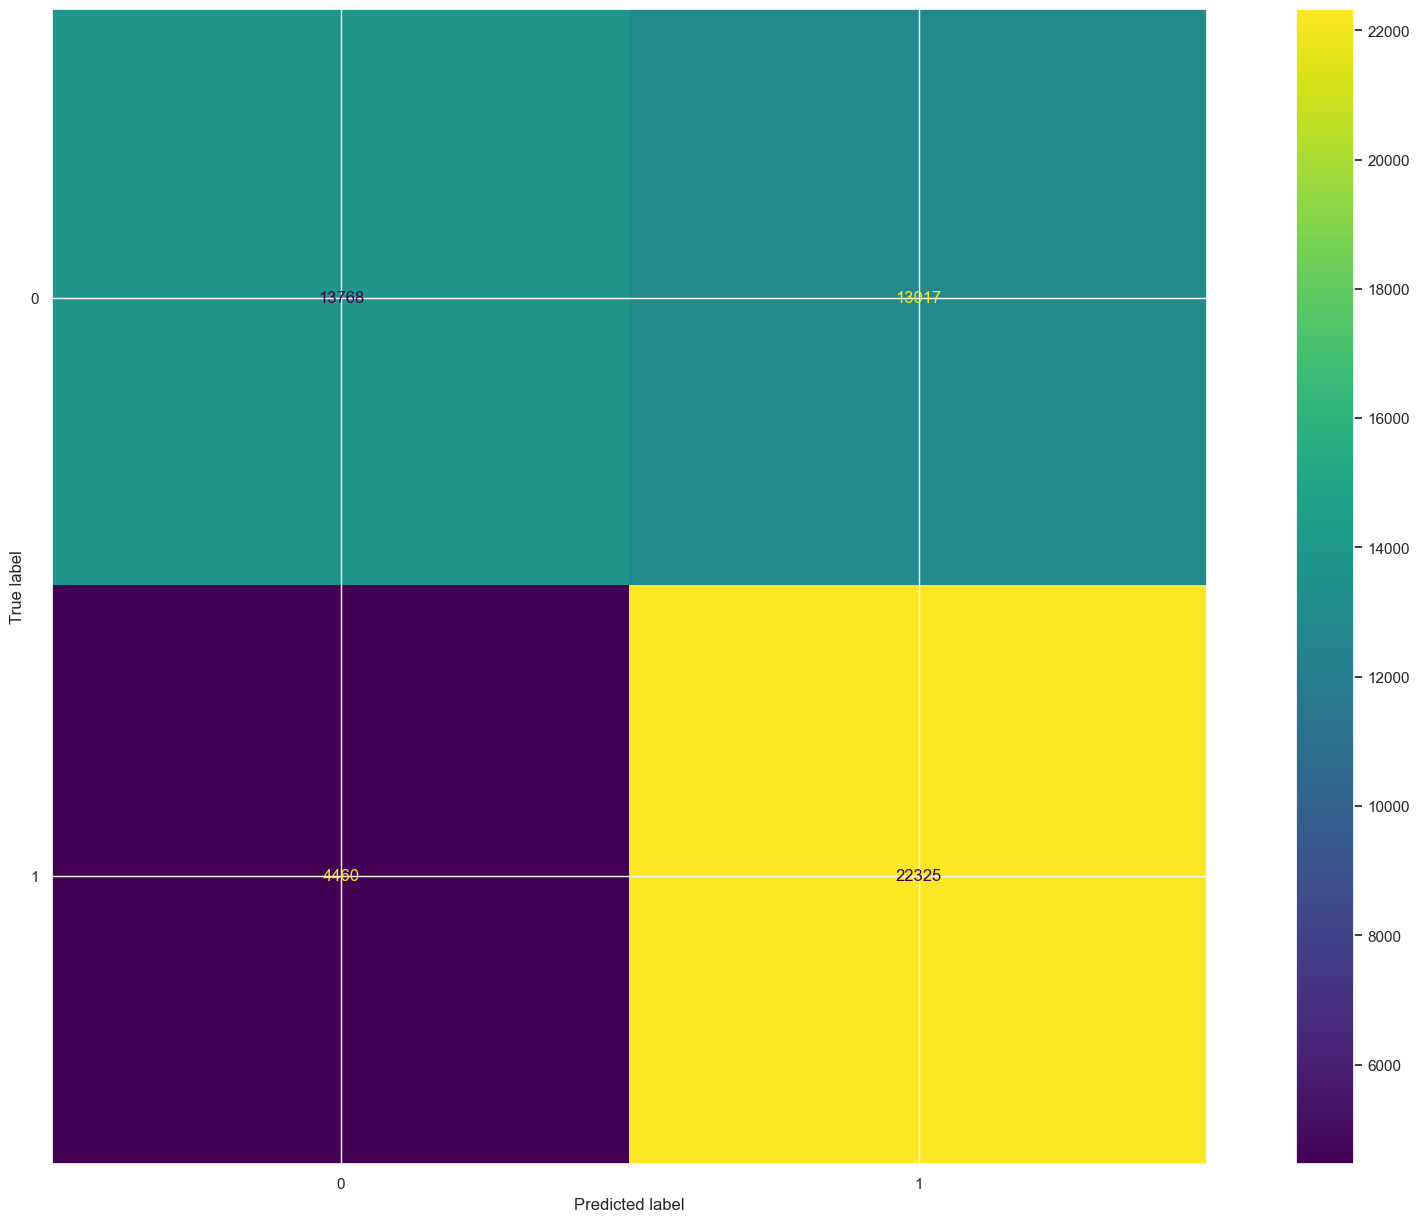

0.6737539667724473

In [101]:
best_rf_model = RandomForestClassifier(n_estimators=1500, min_samples_split= 2, min_samples_leaf= 2, max_depth=21, bootstrap= False )
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)
confusion_matrix(y_test, y_pred)
confusion= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.show()

accuracy_score(y_test, y_pred)


In [102]:
y_pred_proba = best_rf_model.predict_proba(X_test)[::,1]

#if told yes, 63
#if no, 78 

rf_accuracy = accuracy_score(y_test, y_pred)
rf_f1= f1_score(y_test, y_pred, average="macro")
rf_precision= precision_score(y_test, y_pred, average="macro")
rf_recall= recall_score(y_test, y_pred, average="macro")
rf_auc = metrics.roc_auc_score(y_test, y_pred_proba)

print(rf_auc)

0.7218957057820714


In [103]:
classifiers_df.loc[len(classifiers_df.index)] = ["Random Forest", rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc]



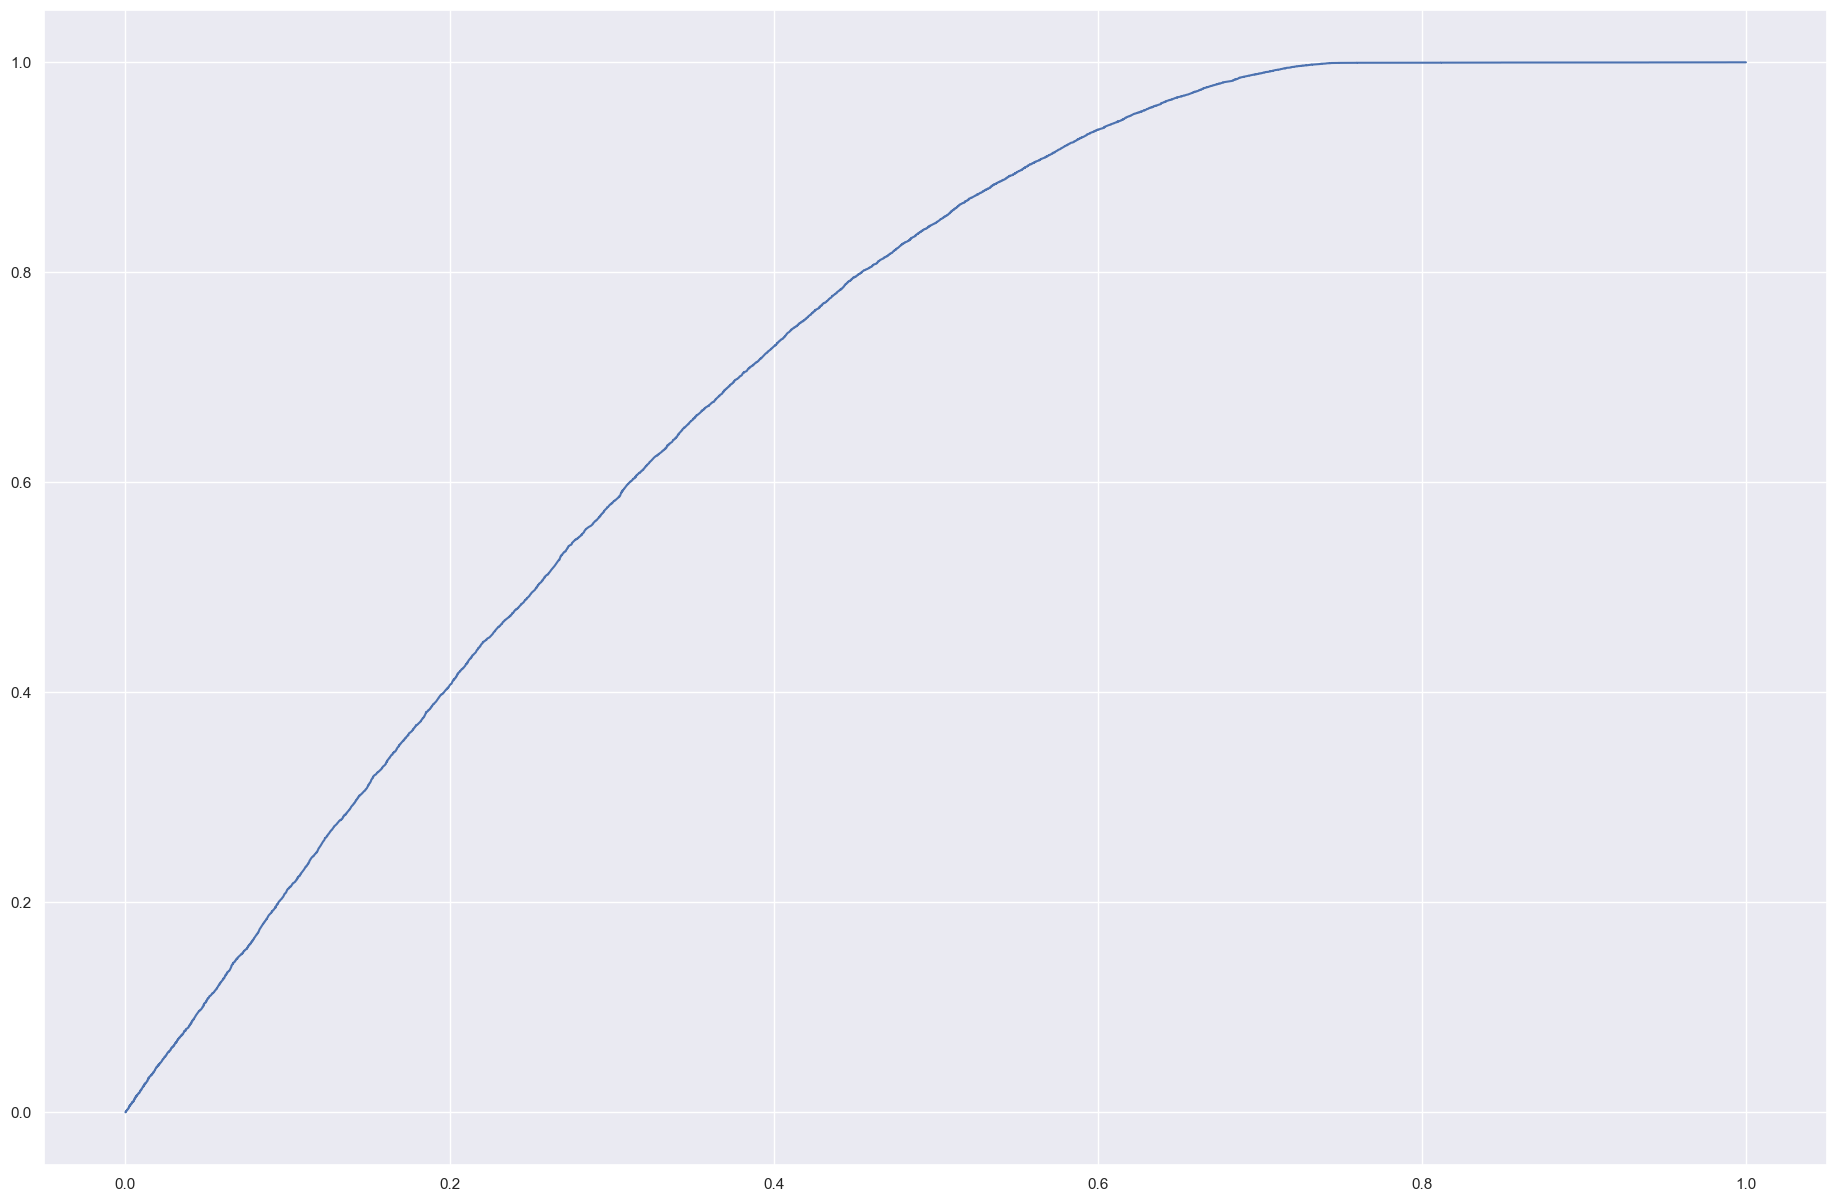

In [104]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))




In [105]:
roc_df.loc[len(roc_df.index)] = ["Random Forest", fpr, tpr, auc]

In [106]:
display(classifiers_df)
display(roc_df)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896


,Classifier,fpr,tpr,auc
0,Random Forest,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00011200298674...",0.7219


Deep Learning (Neural Network)

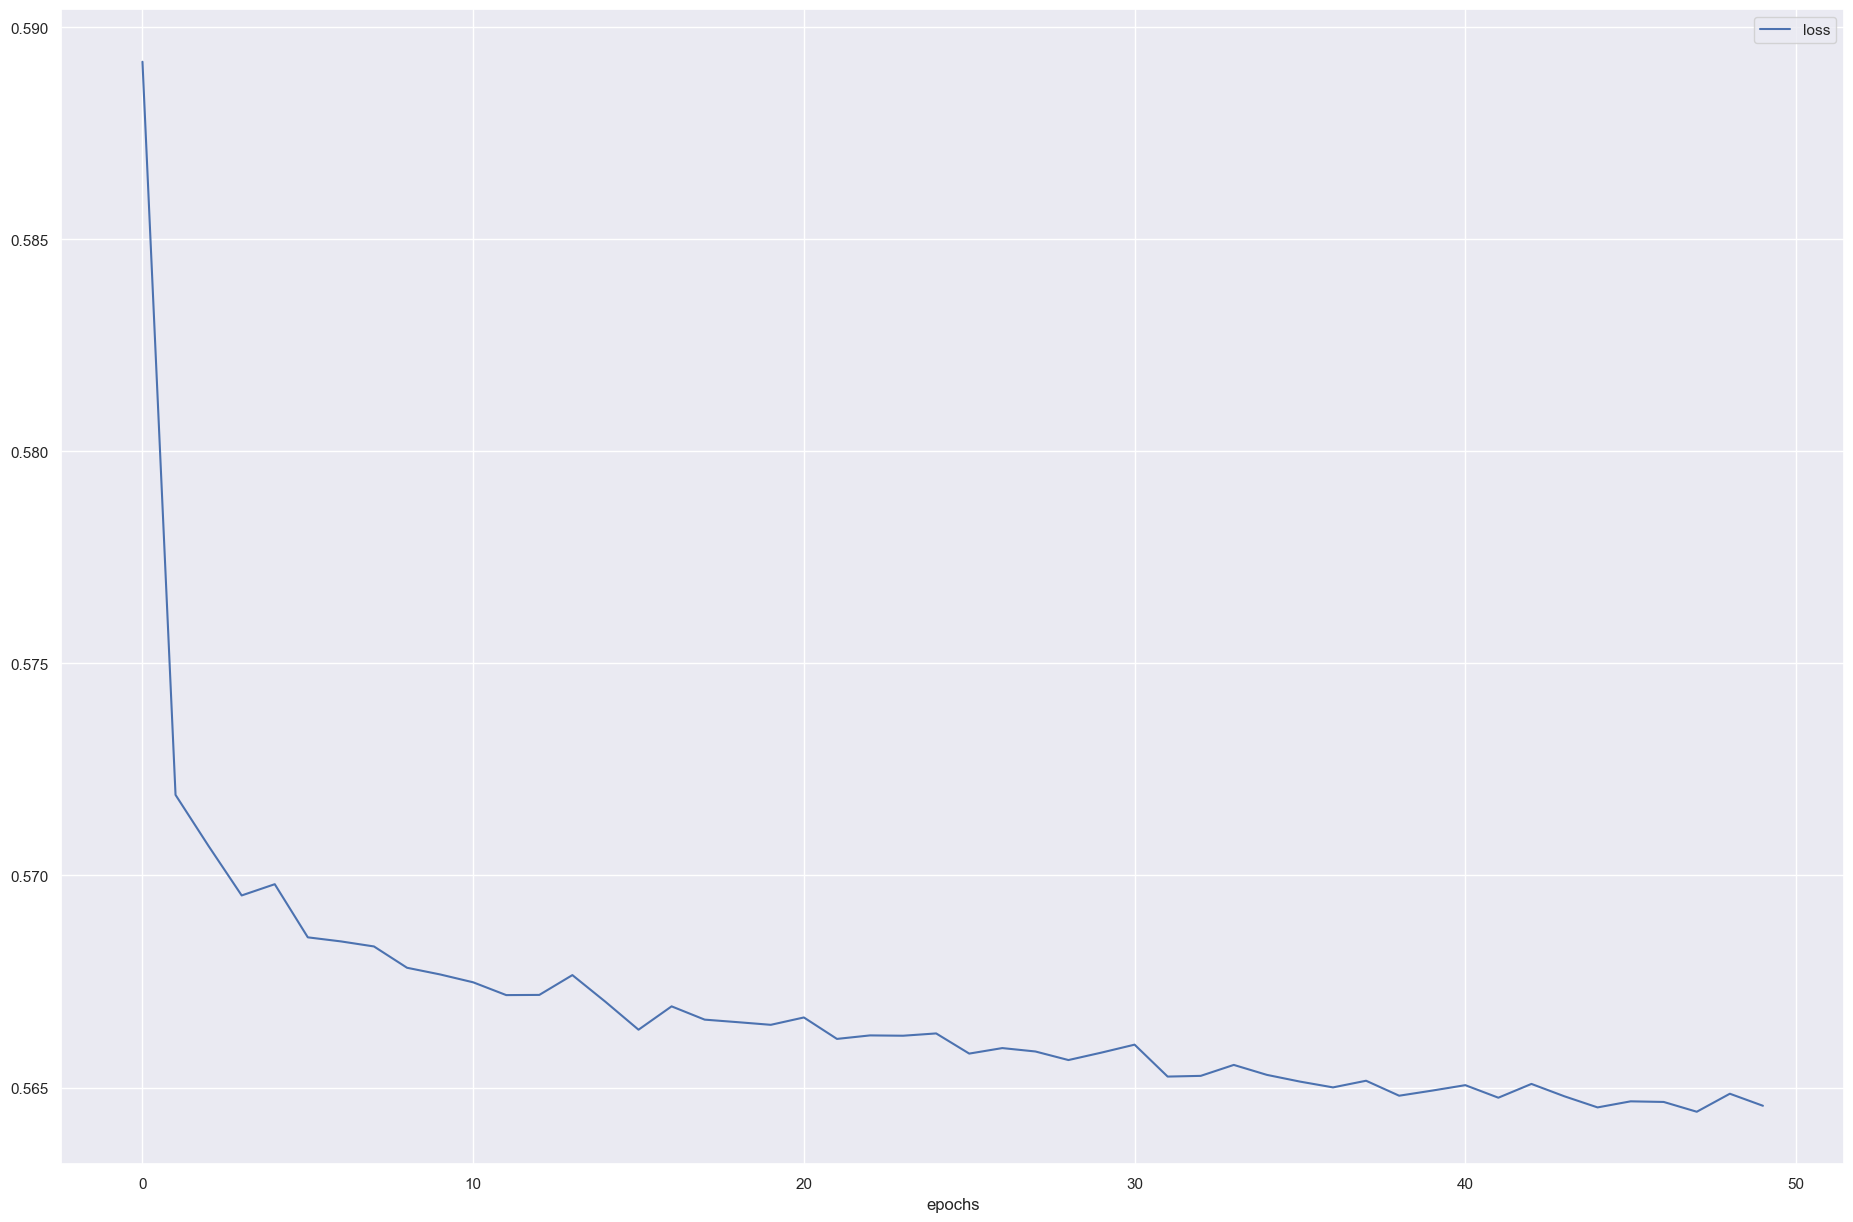

1655/1655 [==============================] - 8s 5ms/step


,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Deep Learning Neural Network,0.679850,0.624977,0.899411,0.737491,0.732040
1,Deep Learning Neural Network,0.620546,0.505693,0.998187,0.671298,0.620546


,Classifier,fpr,tpr,auc
0,Deep Learning Neural Network,"[0.0, 0.0, 0.00011332300834812829, 0.000113323...","[0.0, 3.7772909269471935e-05, 3.77729092694719...",0.7321
1,Deep Learning Neural Network,"[0.0, 3.777433611604276e-05, 0.000151097344464...","[0.0, 0.0, 0.0, 0.0, 3.7772909269471935e-05, 3...",0.6243


In [66]:
def neural_network(X_train, X_test, y_train, y_test):
    import keras
    nn_model = tf.keras.Sequential([
   
      # Flatten Layer that converts images to 1D array
      tf.keras.layers.Flatten(),
   
      # Hidden Layer with 512 units and relu activation
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(units=512, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),

      tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    #run the model
    nn_model.compile(
      loss = 'binary_crossentropy',
      optimizer = 'adam',
      metrics = ['accuracy']
    )
    
    history = nn_model.fit(
        x =  X_train,
        y = y_train,
        batch_size=128,
        epochs = 50)
    
    # Showing plot for loss
    plt.plot(history.history['loss'])
    plt.xlabel('epochs')
    plt.legend(['loss'])
    plt.show()
     
     #Showing plot for accuracy
    plt.plot(history.history['accuracy'], color='orange')
    plt.xlabel('epochs')
    plt.legend(['accuracy'])
    plt.show()
    
    
    #loss and accuracy
    nn_loss, nn_accuracy = nn_model.evaluate(
      x = X_test, 
      y = y_test
    )
    
    #predict test data 
    y_pred = nn_model.predict(X_test)
    #precision
    nn_precision = keras.metrics.Precision()
    nn_precision.update_state(y_test, y_pred)
    nn_precision= tf.get_static_value(nn_precision.result())
    #recall
    nn_recall = keras.metrics.Recall()
    nn_recall.update_state(y_test, y_pred)
    nn_recall= tf.get_static_value(nn_recall.result())
    #f1
    nn_f1 = 2 * (nn_precision * nn_recall) / (nn_precision + nn_recall)
    #AUC
    nn_auc = keras.metrics.AUC()
    nn_auc.update_state(y_test, y_pred)
    nn_auc= tf.get_static_value(nn_auc.result())
    
    
    classifiers_df.loc[len(classifiers_df.index)] = ["Deep Learning Neural Network", nn_accuracy, nn_precision, nn_recall, nn_f1, nn_auc]

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    roc_df.loc[len(roc_df.index)] = ["Deep Learning Neural Network", fpr, tpr, auc]
     

neural_network(X_train, X_test, y_train, y_test)
display(classifiers_df)
display(roc_df)

MLP

In [48]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(32, 64),
                    max_iter=100, random_state=42)

mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(32, 64), max_iter=100, random_state=42)

In [114]:
y_pred = mlp_model.predict(X_test)
y_pred_proba = mlp_model.predict_proba(X_test)[::,1]


mlp_accuracy = accuracy_score(y_test, y_pred)
mlp_f1= f1_score(y_test, y_pred, average="macro")
mlp_precision= precision_score(y_test, y_pred, average="macro")
mlp_recall= recall_score(y_test, y_pred, average="macro")
mlp_auc = metrics.roc_auc_score(y_test, y_pred_proba)



classifiers_df.loc[len(classifiers_df.index)] = ["Multi Layer Perceptron", mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_auc]


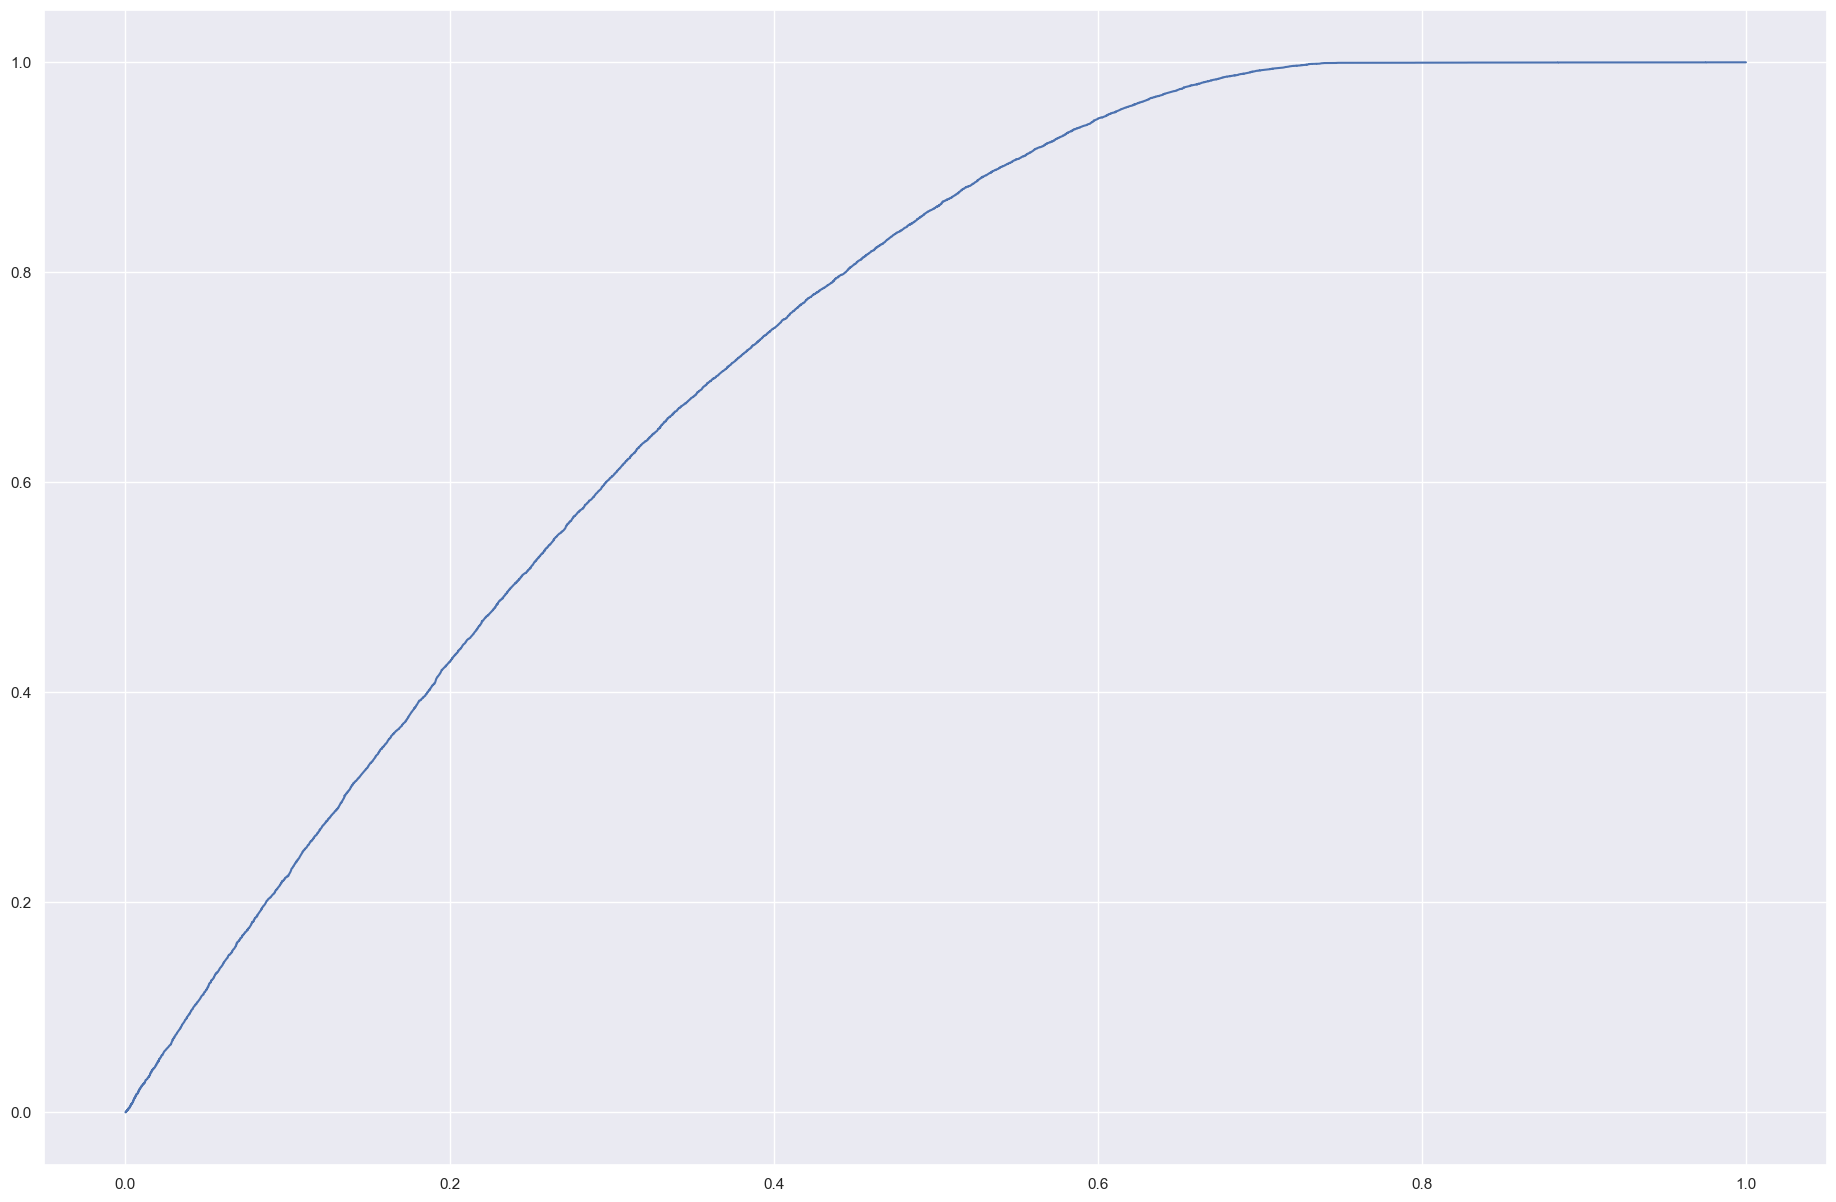

In [115]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
plt.plot(fpr,tpr,label="Multi Layer Perceptron, AUC="+str(auc))

roc_df.loc[len(roc_df.index)] = ["Multi Layer Perceptron", fpr, tpr, auc]

In [116]:
display(classifiers_df)
display(roc_df)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896
1,Deep Learning Neural Network,0.680959,0.640525,0.824827,0.721086,0.734198
2,Multi Layer Perceptron,0.676965,0.685075,0.676965,0.673387,0.732753


,Classifier,fpr,tpr,auc
0,Random Forest,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00011200298674...",0.7219
1,Deep Learning Neural Network,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00052268060481...",0.7343
2,Multi Layer Perceptron,"[0.0, 3.7334328915437745e-05, 3.73343289154377...","[0.0, 0.0, 3.7334328915437745e-05, 3.733432891...",0.7328


# K Nearest Neighbour

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6213552361396304


Text(0, 0.5, 'Accuracy Score')

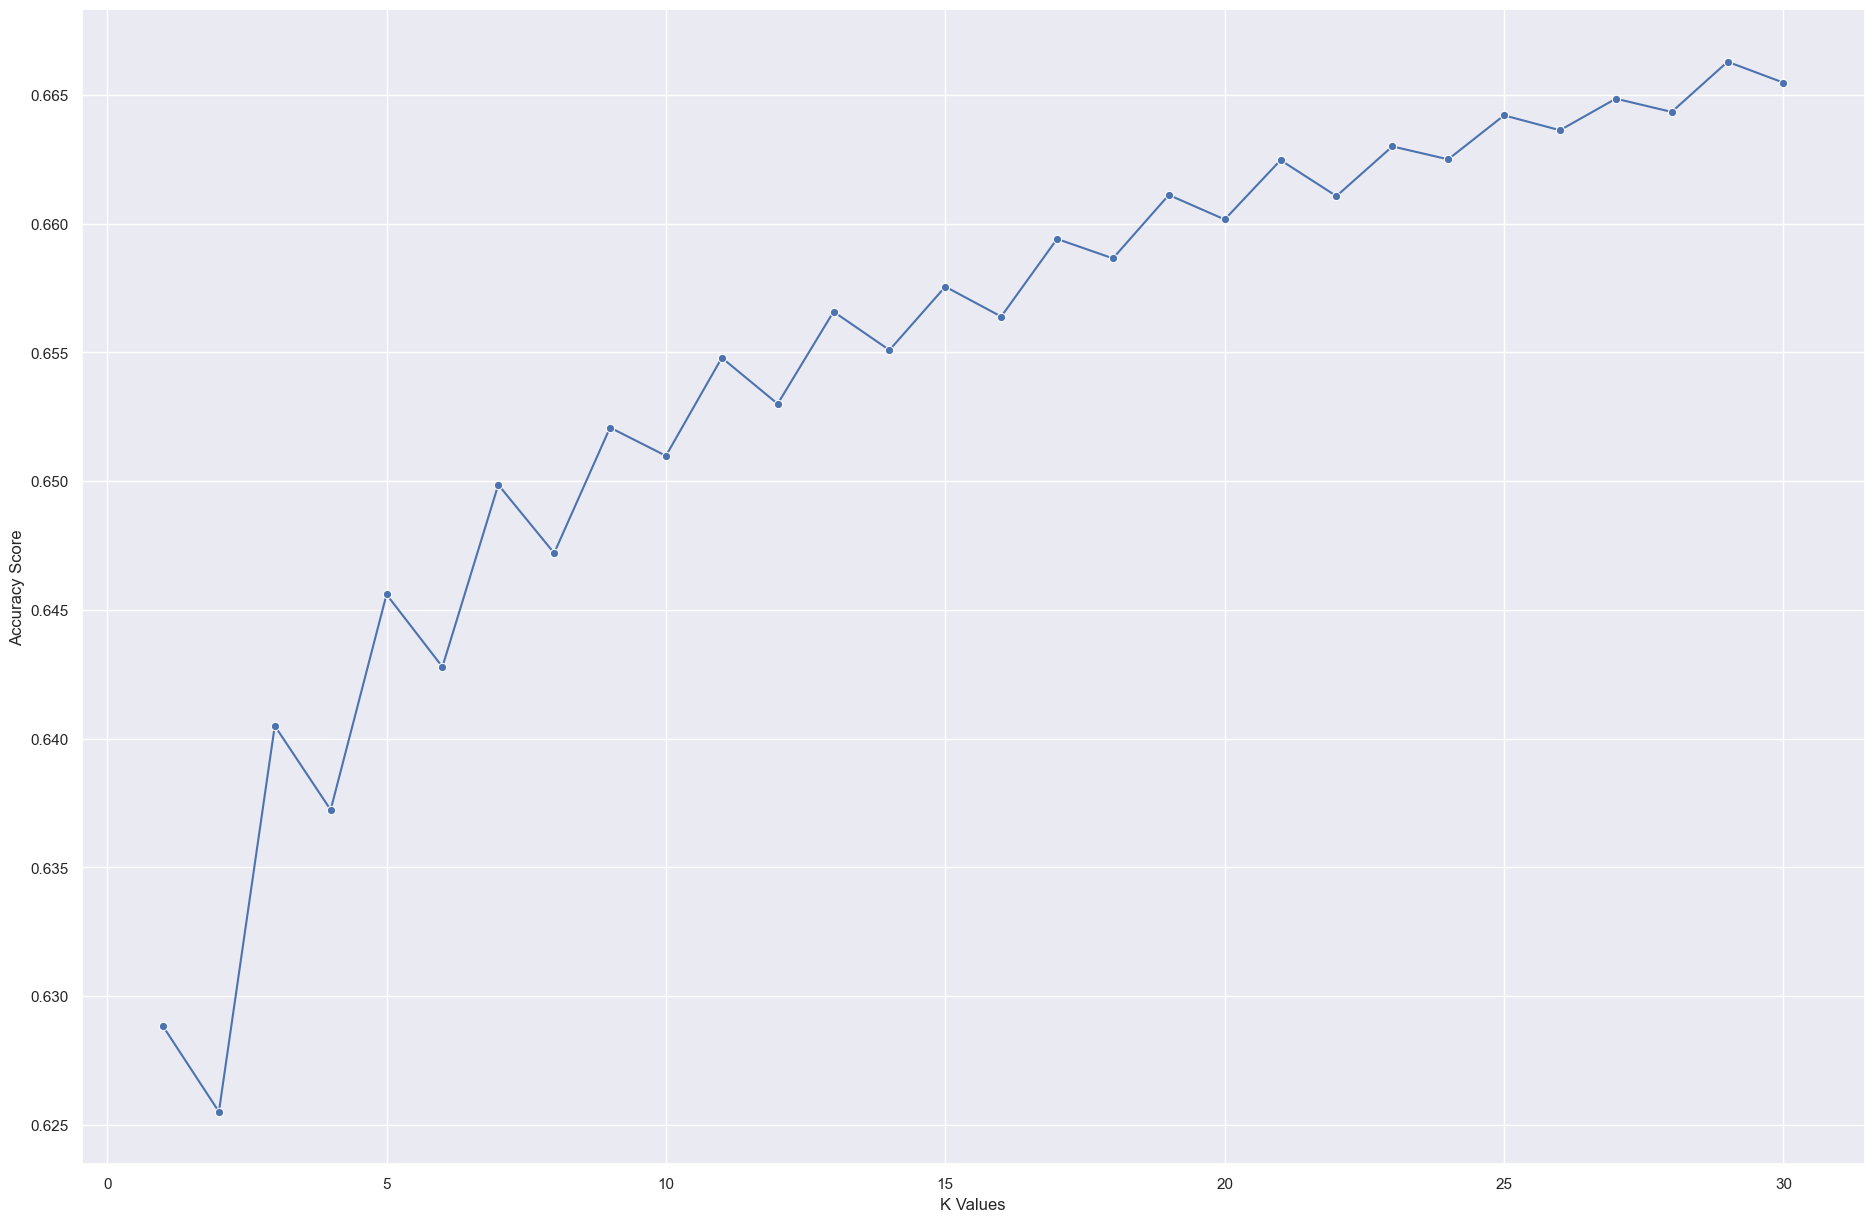

In [53]:
from sklearn.model_selection import cross_val_score
k_values = [i for i in range (1,31)]
scores = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))
    
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [117]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.669983199551988


In [118]:
y_pred_proba = knn.predict_proba(X_test)[::,1]


knn_accuracy = accuracy_score(y_test, y_pred)
knn_f1= f1_score(y_test, y_pred, average="macro")
knn_precision= precision_score(y_test, y_pred, average="macro")
knn_recall= recall_score(y_test, y_pred, average="macro")
knn_auc = metrics.roc_auc_score(y_test, y_pred_proba)



classifiers_df.loc[len(classifiers_df.index)] = ["K Nearest Neighbours", knn_accuracy, knn_precision, knn_recall, knn_f1, knn_auc]

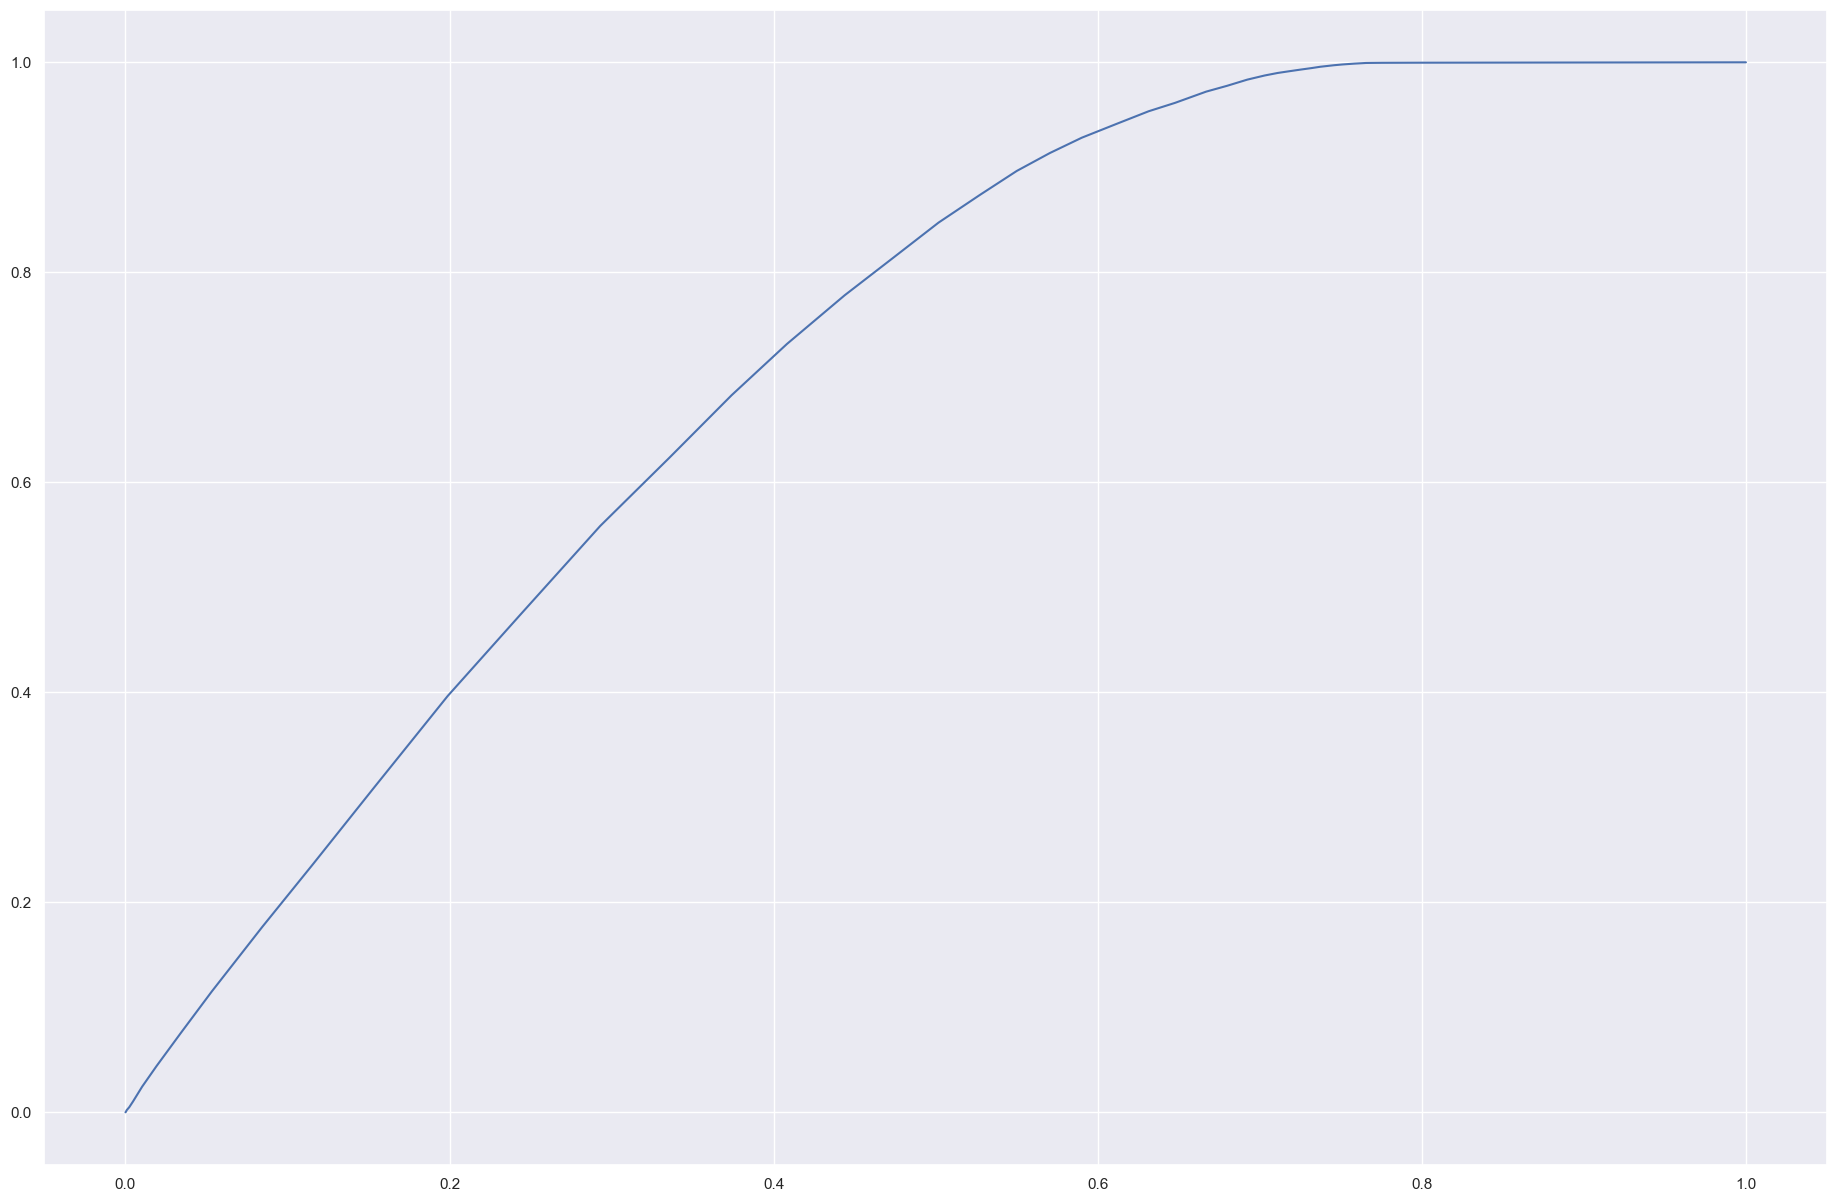

In [119]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
plt.plot(fpr,tpr,label="K Nearest Neighbours, AUC="+str(auc))

roc_df.loc[len(roc_df.index)] = ["K Nearest Neighbours", fpr, tpr, auc]

In [120]:
display(classifiers_df)
display(roc_df)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896
1,Deep Learning Neural Network,0.680959,0.640525,0.824827,0.721086,0.734198
2,Multi Layer Perceptron,0.676965,0.685075,0.676965,0.673387,0.732753
3,K Nearest Neighbours,0.669983,0.685197,0.669983,0.663063,0.717528


,Classifier,fpr,tpr,auc
0,Random Forest,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00011200298674...",0.7219
1,Deep Learning Neural Network,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00052268060481...",0.7343
2,Multi Layer Perceptron,"[0.0, 3.7334328915437745e-05, 3.73343289154377...","[0.0, 0.0, 3.7334328915437745e-05, 3.733432891...",0.7328
3,K Nearest Neighbours,"[0.0, 0.00011200298674631323, 0.00044801194698...","[0.0, 0.00014933731566175098, 0.00100802688071...",0.7175


Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier



# Number of trees in random forest
max_depth = [100,250,500]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 5, 6, 7]
# Method of selecting samples for training each tree

random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'max_depth': [100, 250, 500, None], 'min_samples_split': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [2, 3, 4, 5, 6, 7]}


In [60]:

dt = DecisionTreeClassifier(random_state=1)
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 10, cv = 3, n_jobs = -1)
# Fit the random search model
dt_random.fit(X_train, y_train)
print(dt_random.best_params_)

{'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 21, 'bootstrap': False}


In [122]:
best_dt_model = DecisionTreeClassifier(min_samples_split= 6, min_samples_leaf= 6, max_depth=7)
best_dt_model.fit(X_train, y_train)
y_pred = best_dt_model.predict(X_test)

In [123]:
y_pred_proba = best_dt_model.predict_proba(X_test)[::,1]


dt_accuracy = accuracy_score(y_test, y_pred)
dt_f1= f1_score(y_test, y_pred, average="macro")
dt_precision= precision_score(y_test, y_pred, average="macro")
dt_recall= recall_score(y_test, y_pred, average="macro")
dt_auc = metrics.roc_auc_score(y_test, y_pred_proba)



classifiers_df.loc[len(classifiers_df.index)] = ["Decision Tree", dt_accuracy, dt_precision, dt_recall, dt_f1, dt_auc]

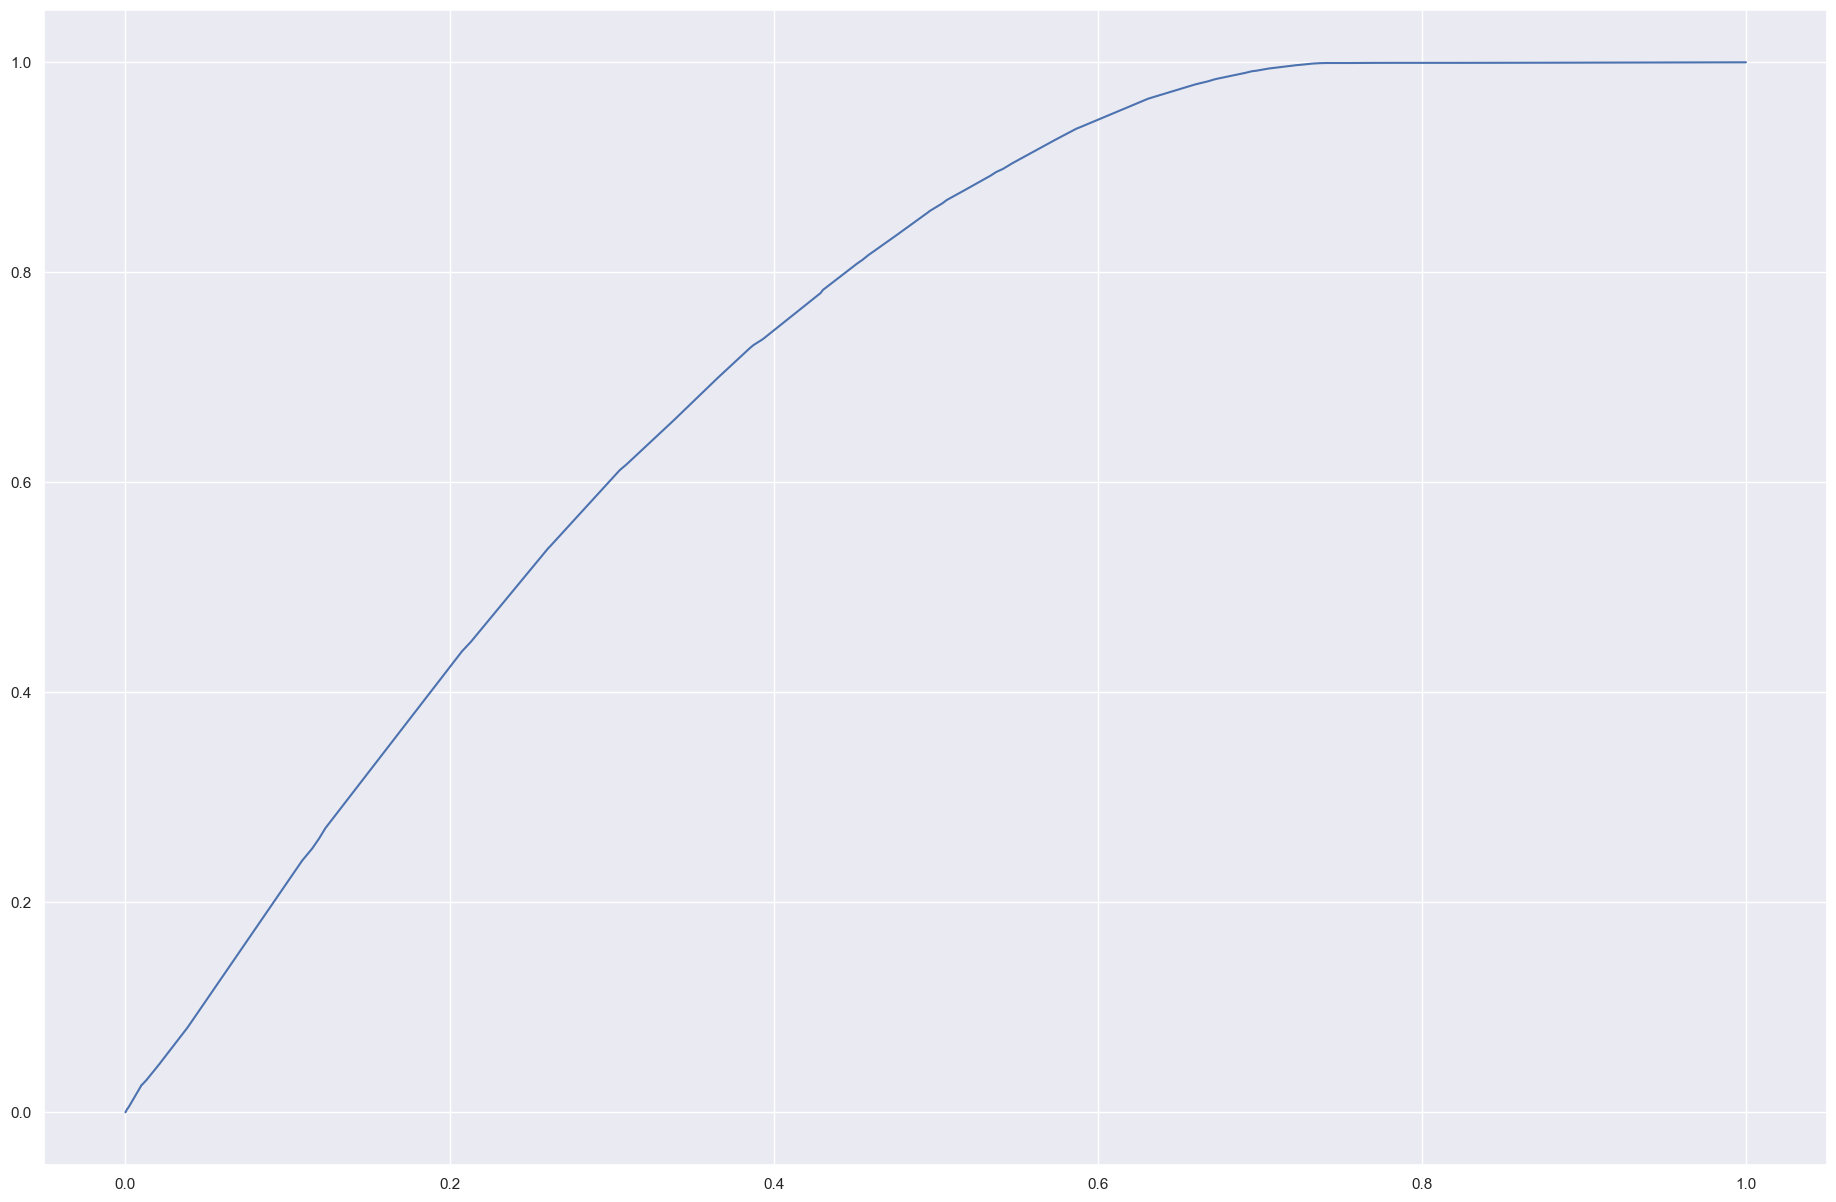

In [124]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

roc_df.loc[len(roc_df.index)] = ["Decision Tree", fpr, tpr, auc]

In [125]:
display(classifiers_df)
display(roc_df)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896
1,Deep Learning Neural Network,0.680959,0.640525,0.824827,0.721086,0.734198
2,Multi Layer Perceptron,0.676965,0.685075,0.676965,0.673387,0.732753
3,K Nearest Neighbours,0.669983,0.685197,0.669983,0.663063,0.717528
4,Decision Tree,0.680941,0.706790,0.680941,0.670648,0.730435


,Classifier,fpr,tpr,auc
0,Random Forest,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00011200298674...",0.7219
1,Deep Learning Neural Network,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00052268060481...",0.7343
2,Multi Layer Perceptron,"[0.0, 3.7334328915437745e-05, 3.73343289154377...","[0.0, 0.0, 3.7334328915437745e-05, 3.733432891...",0.7328
3,K Nearest Neighbours,"[0.0, 0.00011200298674631323, 0.00044801194698...","[0.0, 0.00014933731566175098, 0.00100802688071...",0.7175
4,Decision Tree,"[0.0, 0.0011946985252940078, 0.001493373156617...","[0.0, 0.003546761246966586, 0.0039201045361209...",0.7304


# Voting Hard + Voting Soft

In [65]:
#Logistic Regression, Decision Tree, Linear Discriminant Analysis, Random Forest, and K Nearest Neighbours

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create different classifiers
clf0 = LogisticRegression(random_state=1)
clf1 = DecisionTreeClassifier(random_state=1)
clf2= LinearDiscriminantAnalysis()
clf3 = RandomForestClassifier(random_state=1)
clf4 = KNeighborsClassifier(n_neighbors=27)

labels = ['Logistic Regression', 'Decision Tree', 'Linear Discriminant Analysis','Random Forest', 'K Nearest Neighbours']

In [66]:
for clf, label in zip([clf0, clf1, clf2, clf3, clf4], labels):

    # Use cross_val_score to compute accuracy scores using 5-fold cross-validation
    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=5, 
                                              scoring='accuracy')
    
    # Print the mean accuracy and standard deviation of accuracy for the current classifier
    print(scores.mean(), label)

C:\Users\rache\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.6484530855567718 Logistic Regression
0.6367813904031336 Decision Tree
0.651886750516704 Linear Discriminant Analysis
0.6490689296884273 Random Forest
0.6648536098755039 K Nearest Neighbours


In [67]:
voting_clf_hard = VotingClassifier(
    estimators=[(labels[0], clf0),  
                (labels[1], clf1),  
                (labels[2], clf2), 
                (labels[3], clf3),
                (labels[4], clf4)],
    voting='hard')

In [68]:
voting_clf_soft = VotingClassifier(
    estimators=[(labels[0], clf0),  
                (labels[1], clf1),  
                (labels[2], clf2), 
                (labels[3], clf3),
                (labels[4], clf4)],
    voting='soft')

In [126]:
voting_clf_hard.fit(X_train, y_train)

# Make predictions and evaluate
y_pred= voting_clf_hard.predict(X_test)


vh_accuracy = accuracy_score(y_test, y_pred)
vh_f1= f1_score(y_test, y_pred, average="macro")
vh_precision= precision_score(y_test, y_pred, average="macro")
vh_recall= recall_score(y_test, y_pred, average="macro")
vh_auc = metrics.roc_auc_score(y_test, y_pred)



classifiers_df.loc[len(classifiers_df.index)] = ["Voting (Hard)", vh_accuracy, vh_precision, vh_recall, vh_f1, vh_auc]

C:\Users\rache\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


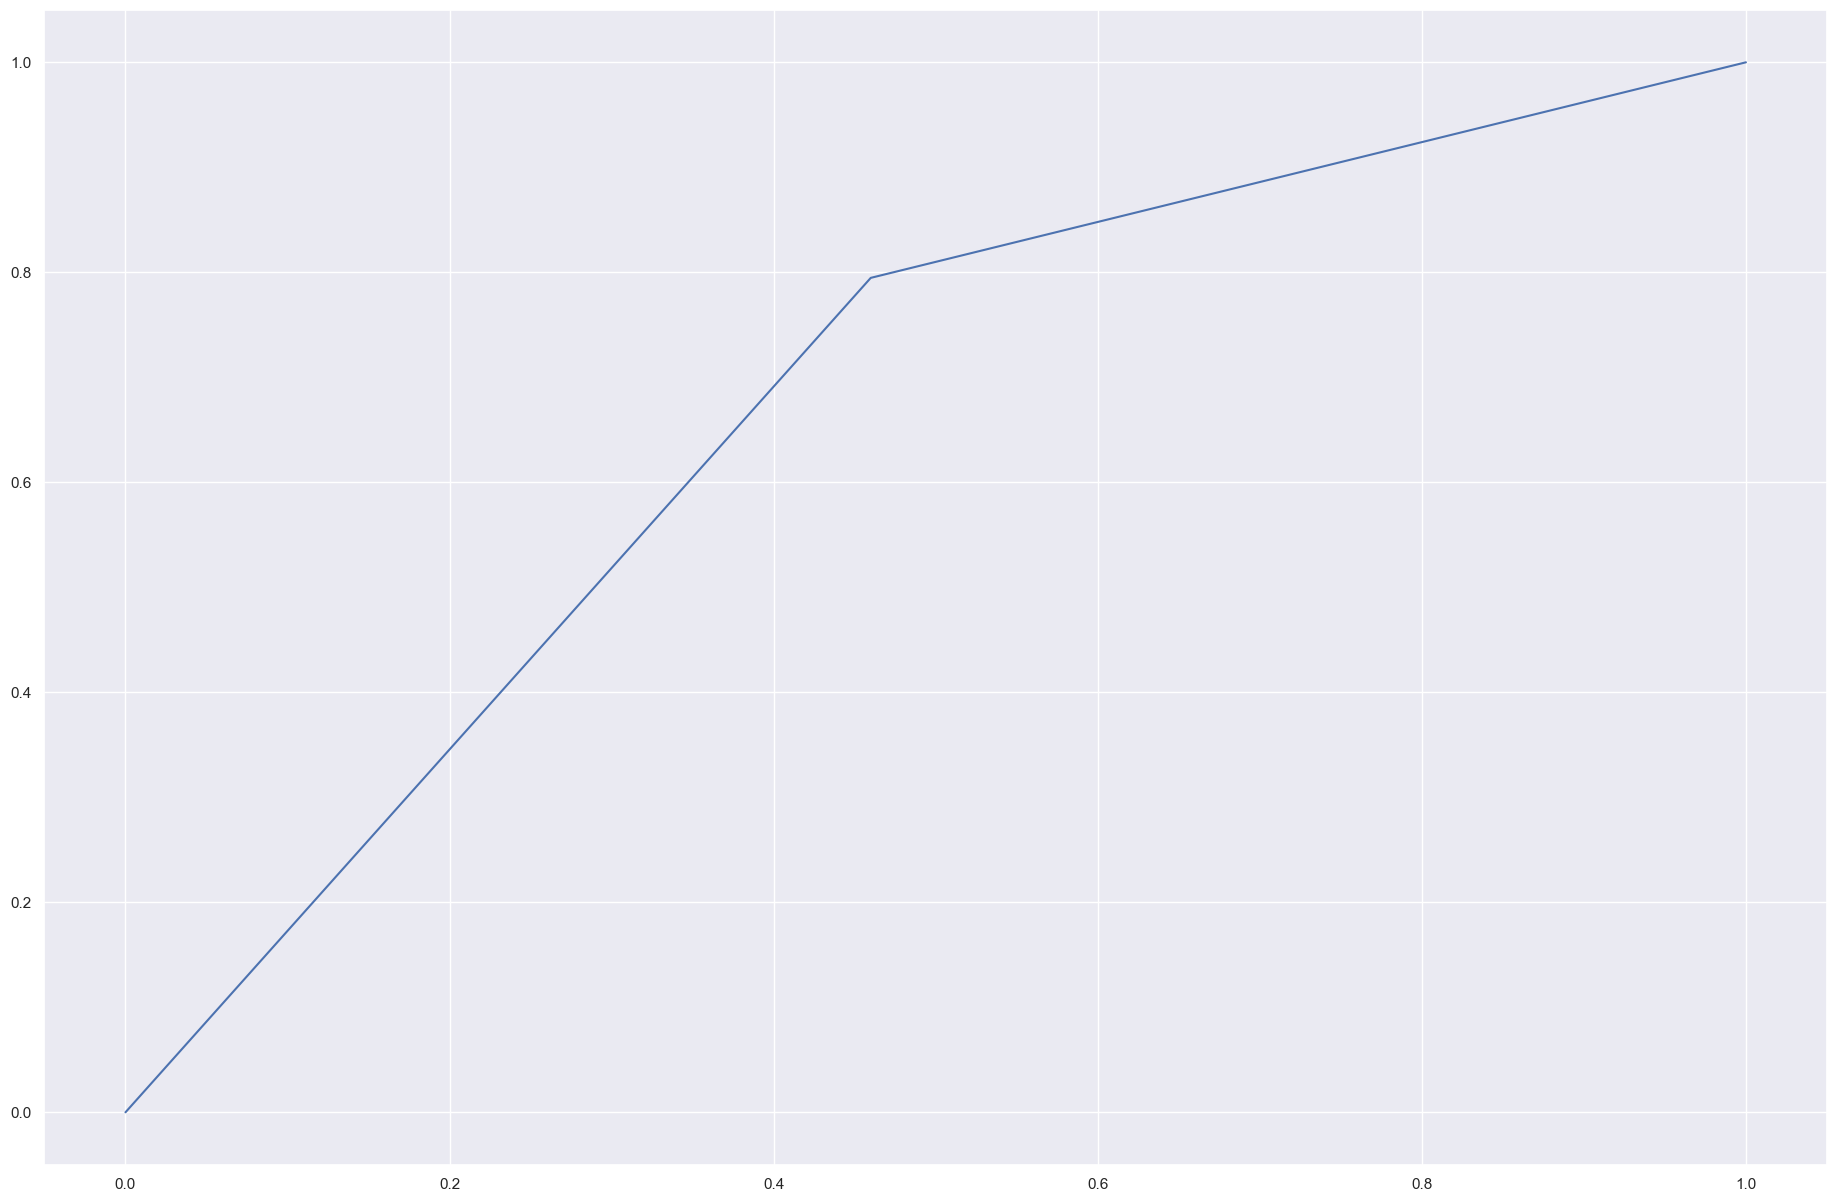

In [127]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Voting (Hard), AUC="+str(auc))

roc_df.loc[len(roc_df.index)] = ["Voting (Hard)", fpr, tpr, auc]

In [128]:
voting_clf_soft.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = voting_clf_soft.predict(X_test)

y_pred_proba = voting_clf_soft.predict_proba(X_test)[::,1]


vs_accuracy = accuracy_score(y_test, y_pred)
vs_f1= f1_score(y_test, y_pred, average="macro")
vs_precision= precision_score(y_test, y_pred, average="macro")
vs_recall= recall_score(y_test, y_pred, average="macro")
vs_auc = metrics.roc_auc_score(y_test, y_pred_proba)



classifiers_df.loc[len(classifiers_df.index)] = ["Voting (Soft)", vs_accuracy, vs_precision, vs_recall, vs_f1, vs_auc]

C:\Users\rache\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


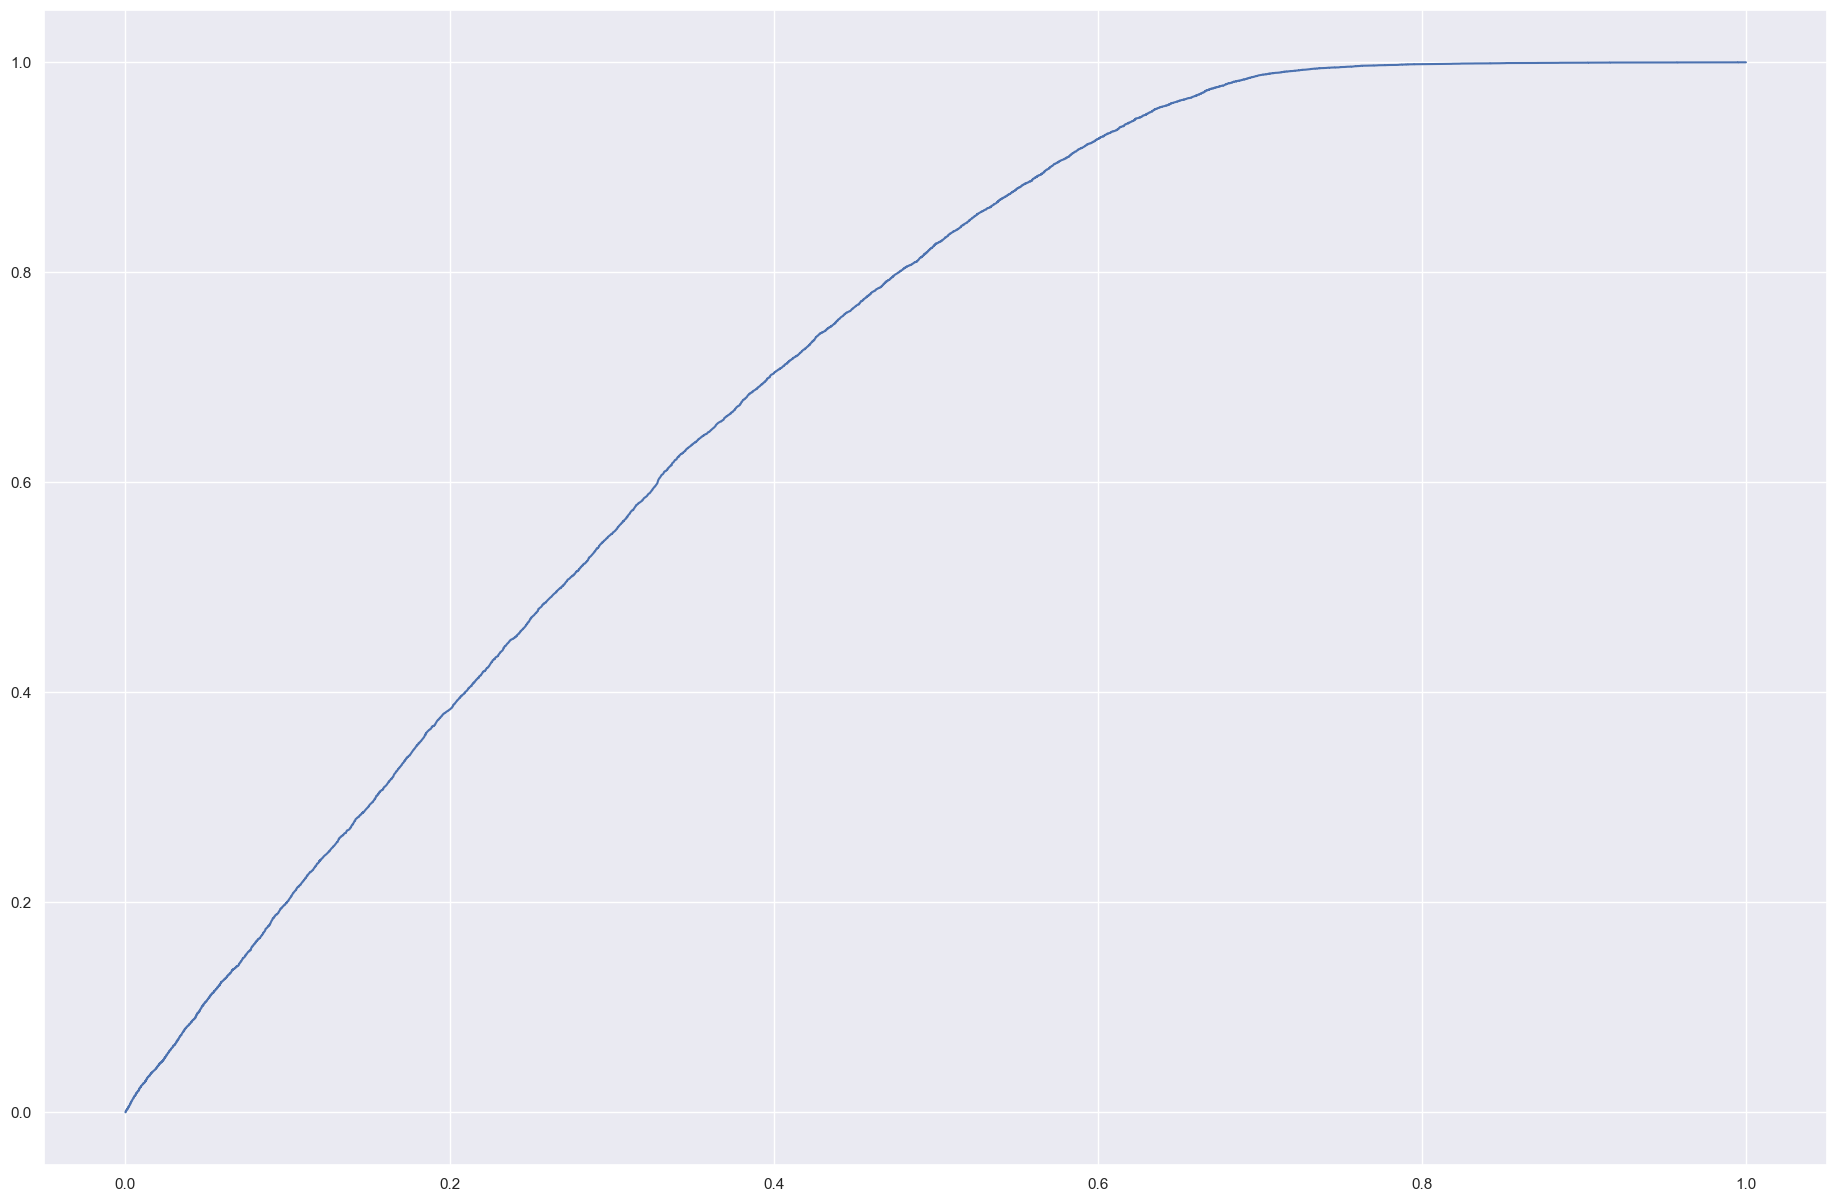

In [129]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
plt.plot(fpr,tpr,label="Voting (Soft), AUC="+str(auc))

roc_df.loc[len(roc_df.index)] = ["Voting (Soft)", fpr, tpr, auc]

In [130]:
display(classifiers_df)
display(roc_df)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896
1,Deep Learning Neural Network,0.680959,0.640525,0.824827,0.721086,0.734198
2,Multi Layer Perceptron,0.676965,0.685075,0.676965,0.673387,0.732753
3,K Nearest Neighbours,0.669983,0.685197,0.669983,0.663063,0.717528
4,Decision Tree,0.680941,0.706790,0.680941,0.670648,0.730435
5,Voting (Hard),0.667388,0.678993,0.667388,0.661909,0.667388
6,Voting (Soft),0.659679,0.669008,0.659679,0.654917,0.709656


,Classifier,fpr,tpr,auc
0,Random Forest,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00011200298674...",0.7219
1,Deep Learning Neural Network,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00052268060481...",0.7343
2,Multi Layer Perceptron,"[0.0, 3.7334328915437745e-05, 3.73343289154377...","[0.0, 0.0, 3.7334328915437745e-05, 3.733432891...",0.7328
3,K Nearest Neighbours,"[0.0, 0.00011200298674631323, 0.00044801194698...","[0.0, 0.00014933731566175098, 0.00100802688071...",0.7175
4,Decision Tree,"[0.0, 0.0011946985252940078, 0.001493373156617...","[0.0, 0.003546761246966586, 0.0039201045361209...",0.7304
5,Voting (Hard),"[0.0, 0.45992159790927756, 1.0]","[0.0, 0.7946985252940079, 1.0]",0.6674
6,Voting (Soft),"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00014933731566...",0.7097


# Adaboost

In [74]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

# base_estimator, n_estimators, and learning_rate.

ada= ada.fit(X_train, y_train)

In [131]:
y_pred= ada.predict(X_test)
y_pred_proba = ada.predict_proba(X_test)[::,1]


ada_accuracy = accuracy_score(y_test, y_pred)
ada_f1= f1_score(y_test, y_pred, average="macro")
ada_precision= precision_score(y_test, y_pred, average="macro")
ada_recall= recall_score(y_test, y_pred, average="macro")
ada_auc = metrics.roc_auc_score(y_test, y_pred_proba)



classifiers_df.loc[len(classifiers_df.index)] = ["AdaBoost", ada_accuracy, ada_precision, ada_recall, ada_f1, ada_auc]

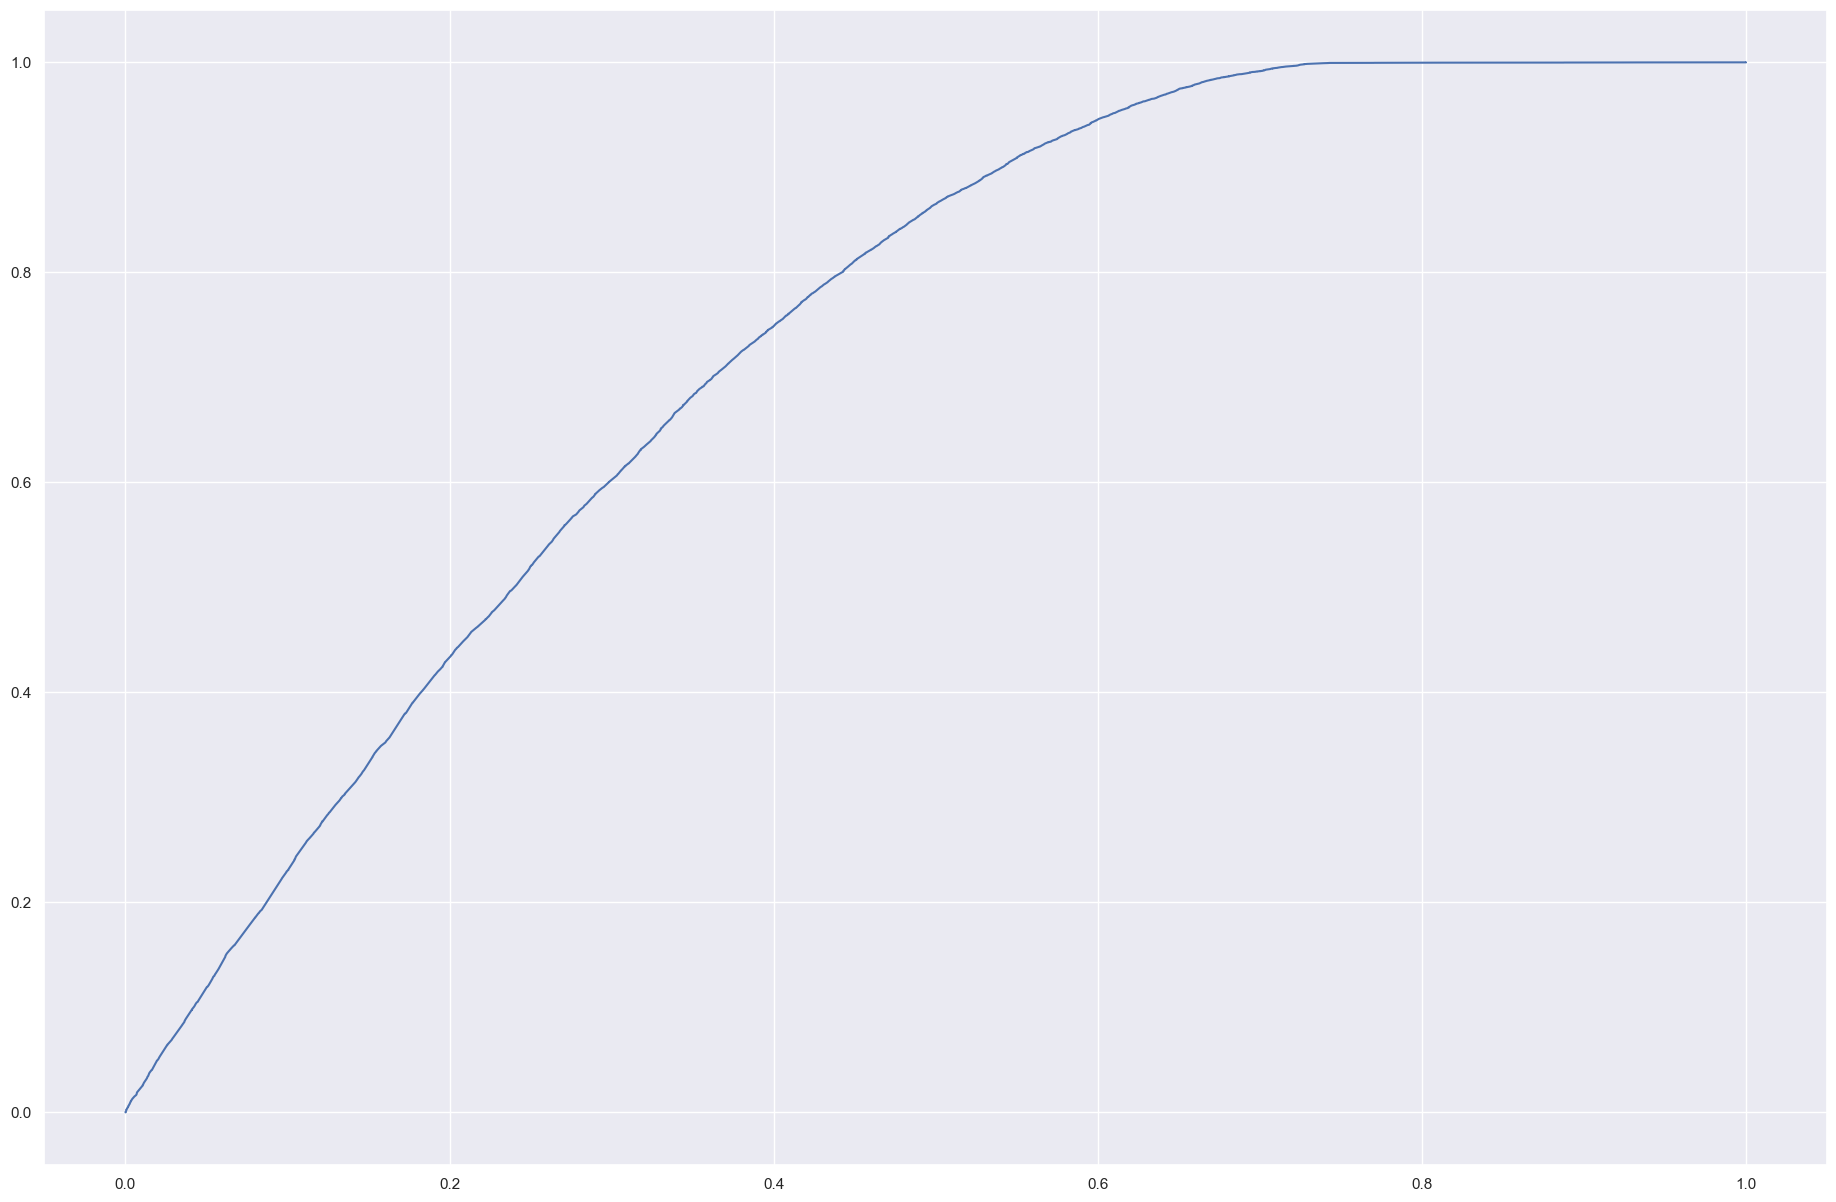

In [132]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
plt.plot(fpr,tpr,label="AdaBoost, AUC="+str(auc))

roc_df.loc[len(roc_df.index)] = ["AdaBoost", fpr, tpr, auc]

In [133]:
display(classifiers_df)
display(roc_df)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896
1,Deep Learning Neural Network,0.680959,0.640525,0.824827,0.721086,0.734198
2,Multi Layer Perceptron,0.676965,0.685075,0.676965,0.673387,0.732753
3,K Nearest Neighbours,0.669983,0.685197,0.669983,0.663063,0.717528
4,Decision Tree,0.680941,0.706790,0.680941,0.670648,0.730435
5,Voting (Hard),0.667388,0.678993,0.667388,0.661909,0.667388
6,Voting (Soft),0.659679,0.669008,0.659679,0.654917,0.709656
7,AdaBoost,0.681613,0.702693,0.681613,0.673114,0.733597


,Classifier,fpr,tpr,auc
0,Random Forest,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00011200298674...",0.7219
1,Deep Learning Neural Network,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00052268060481...",0.7343
2,Multi Layer Perceptron,"[0.0, 3.7334328915437745e-05, 3.73343289154377...","[0.0, 0.0, 3.7334328915437745e-05, 3.733432891...",0.7328
3,K Nearest Neighbours,"[0.0, 0.00011200298674631323, 0.00044801194698...","[0.0, 0.00014933731566175098, 0.00100802688071...",0.7175
4,Decision Tree,"[0.0, 0.0011946985252940078, 0.001493373156617...","[0.0, 0.003546761246966586, 0.0039201045361209...",0.7304
5,Voting (Hard),"[0.0, 0.45992159790927756, 1.0]","[0.0, 0.7946985252940079, 1.0]",0.6674
6,Voting (Soft),"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00014933731566...",0.7097
7,AdaBoost,"[0.0, 0.0, 3.7334328915437745e-05, 7.466865783...","[0.0, 3.7334328915437745e-05, 3.73343289154377...",0.7336


Notes

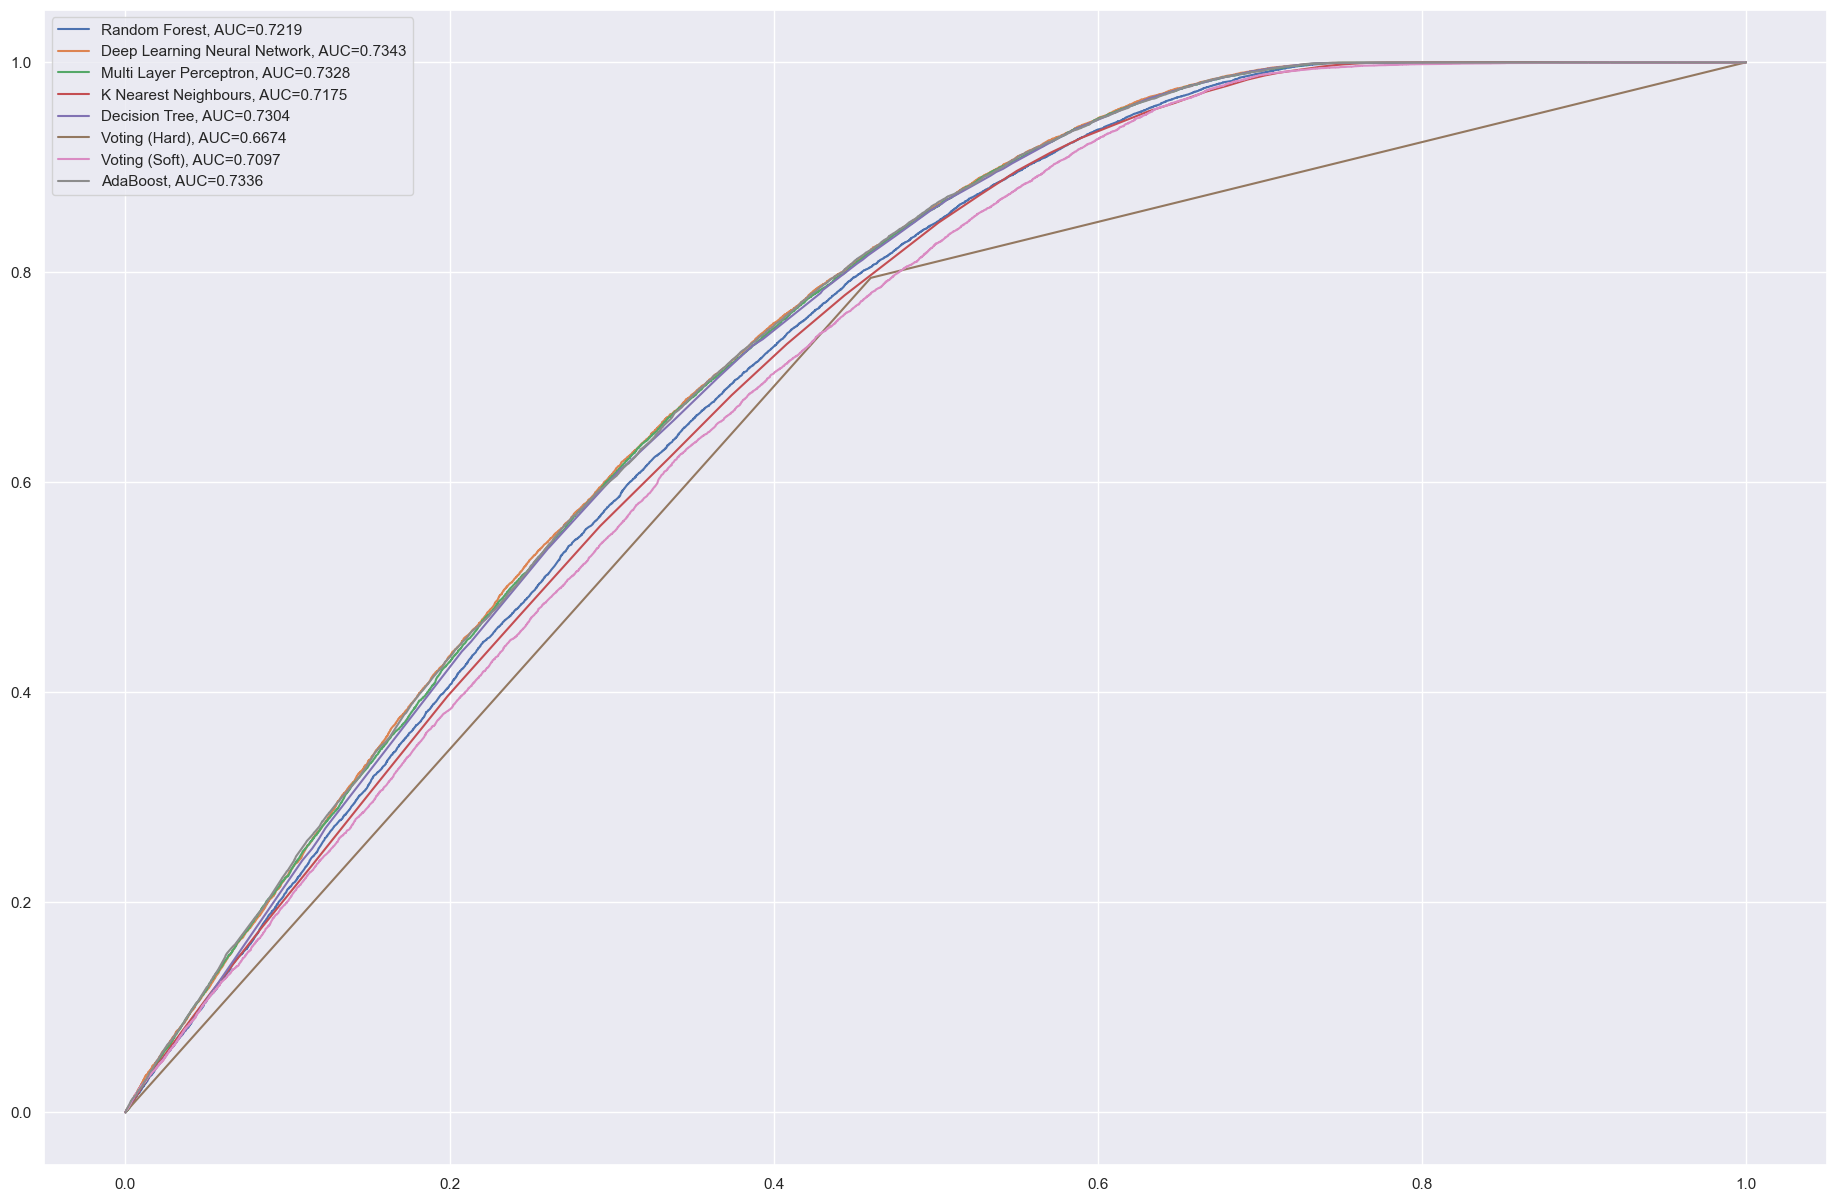

In [134]:
#TEST

plt.plot(roc_df['fpr'][0], roc_df['tpr'][0],label= str(roc_df['Classifier'][0])+ ", AUC=" + str(roc_df['auc'][0]))
plt.plot(roc_df['fpr'][1], roc_df['tpr'][1],label= str(roc_df['Classifier'][1]) + ", AUC=" +str(roc_df['auc'][1]))
plt.plot(roc_df['fpr'][2], roc_df['tpr'][2],label= str(roc_df['Classifier'][2]) + ", AUC=" +str(roc_df['auc'][2]))
plt.plot(roc_df['fpr'][3], roc_df['tpr'][3],label= str(roc_df['Classifier'][3]) + ", AUC=" +str(roc_df['auc'][3]))
plt.plot(roc_df['fpr'][4], roc_df['tpr'][4],label= str(roc_df['Classifier'][4]) + ", AUC=" +str(roc_df['auc'][4]))
plt.plot(roc_df['fpr'][5], roc_df['tpr'][5],label= str(roc_df['Classifier'][5]) + ", AUC=" +str(roc_df['auc'][5]))
plt.plot(roc_df['fpr'][6], roc_df['tpr'][6],label= str(roc_df['Classifier'][6]) + ", AUC=" +str(roc_df['auc'][6]))
plt.plot(roc_df['fpr'][7], roc_df['tpr'][7],label= str(roc_df['Classifier'][7]) + ", AUC=" +str(roc_df['auc'][7]))

plt.legend()

In [135]:
classifiers_df.style.highlight_max(color = 'yellow', axis = 0)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896
1,Deep Learning Neural Network,0.680959,0.640525,0.824827,0.721086,0.734198
2,Multi Layer Perceptron,0.676965,0.685075,0.676965,0.673387,0.732753
3,K Nearest Neighbours,0.669983,0.685197,0.669983,0.663063,0.717528
4,Decision Tree,0.680941,0.706790,0.680941,0.670648,0.730435
5,Voting (Hard),0.667388,0.678993,0.667388,0.661909,0.667388
6,Voting (Soft),0.659679,0.669008,0.659679,0.654917,0.709656
7,AdaBoost,0.681613,0.702693,0.681613,0.673114,0.733597
